## Project Overview
This project aims to guide the establishment of a new movie studio by providing actionable insights into the key factors driving box office success. We explore data from IMDB, The Movie Database (TMDb), and the finaancial numbers to understand what types of movies perform well at the box office. The goal is to extract patterns in genres, ratings, and other characteristics to guide the studio’s production strategy.

## Business Objectives
The new movie studio lacks experience in movie making and needs insights to:
- Identify successful movie characteristics.
- Pinpoint profitable genres.
- Determine optimal budget ranges.
- Strategize release timings to maximize box office revenue.

## Data Understanding
The dataset used for this project combines information from multiple sources, each offering unique and complementary insights into movie attributes and box office performance. Below is a breakdown of the data sources used and the specific datasets obtained from each.

###  Data Sources and Datasets

1. [Box Office Mojo](https://www.boxofficemojo.com/) 
Provides comprehensive box office earnings of other studios including (domestic and international) revenue data.
   - bom.movie_gross.csv.gz 

2. [IMDB (Internet Movie Database)](https://www.imdb.com/) 
Comprehensive movie database featuring production details, cast and crew (including directors, writers, actors, and producers), user ratings and votes, as well as metadata such as title, release year, runtime, genre, and biographical information.
   - imdb.title.crew.csv.gz
   - imdb.title.akas.csv.gz
   - imdb.title.ratings.csv.gz
   - imdb.name.basics.csv.gz
   - imdb.title.basics.csv.gz
   - imdb.title.principals.csv.gz

3. [The Movie Database (TMDb)](https://www.themoviedb.org/) 
Collaborative movie database providing community sourced metadata such as popularity, vote count, and original language
   - tmdb.movies.csv.gz

4. [The Numbers](https://www.the-numbers.com/) 
Provides financial data on movies, including production budgets, worldwide gross, and estimated profits
   - tn.movie_budgets.csv.gz


###  Datasets Used in Analysis
After performing an initial analysis, cleaning, and merging of data, we used the following datasets for analysis:

- `tn.movie_budgets.csv.gz` → Used for financial and studio performance analysis (budget, gross, profit, ROI).
- `bom.movie_gross.csv.gz` → Supplementary financial data, focusing on domestic and international gross.
- `imdb.title.basics.csv.gz` → Used to extract genre, runtime, and title information.
- `imdb.title.akas.csv.gz` & `imdb.title.principals.csv.gz` → Contains Movie Metadata like genre, runtimes, directors, actors, and producers for talent influence.


### Exploratory Data Analysis (EDA)

- We performed basic data cleaning using Python, including converting data types where necessary, removing missing values that could significantly impact our analysis, and identifying potential outliers.
New columns were added based on the needs of the analysis or the outcomes we wanted. We also carried out exploratory analysis to understand data distributions and spot anomalies early in the process. 
To maximize the usefulness of the data, we merged datasets to enrich the information available allowing us to have a better understand of the business problem.

- To address the business problem of helping a new movie studio with no prior movie making experience, we structured our analysis around these
key pillars:

1. Financial performance metrics

2. Market landscape

3. Audience preference

4. Movie characteristics

## Financial Performance Metric

#### Extracting Datasets from The Numbers dataset

In [110]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split   # for splitting data into training and testing sets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import seaborn as sns
from itertools import combinations
import ast
import sqlite3

In [111]:
# Loading the numbers dataset 
tn = pd.read_csv("Data/tn.movie_budgets.csv")
tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [112]:
# Understanding the data structure
tn.info()

print("Shape:", tn.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB
Shape: (5782, 6)


#### Data Type Conversion and Cleaning

- Converted the release_date column from string format to datetime for proper date handling.
- Cleaned the currency columns (production_budget, domestic_gross, worldwide_gross) by removing dollar signs and commas, then converted them to 64-bit integers for numerical analysis.

In [113]:
# Convert release_date to datetime
tn['release_date'] = pd.to_datetime(tn['release_date'])

# Remove $ and , and convert to integers
cols_to_clean = ['production_budget', 'domestic_gross', 'worldwide_gross']
for col in cols_to_clean:
    tn[col] = tn[col].replace('[\$,]', '', regex=True).astype('int64')


# Output
print(tn.dtypes)
tn.head()

<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
C:\Users\user\AppData\Local\Temp\ipykernel_37268\1856749992.py:7: SyntaxWarning: invalid escape sequence '\$'
  tn[col] = tn[col].replace('[\$,]', '', regex=True).astype('int64')


id                            int64
release_date         datetime64[ns]
movie                        object
production_budget             int64
domestic_gross                int64
worldwide_gross               int64
dtype: object


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


#### Column Restructuring

- Removed the id column from the dataset.
- Created a new column  Release year by extracting the year component from the release_date column. 

In [114]:
# Drop the 'id' column
tn = tn.drop(columns=['id'])

# Extract year from 'release_date' and create a new 'year' column
tn['release_year'] = tn['release_date'].dt.year

# Now print to see the result
tn.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
0,2009-12-18,Avatar,425000000,760507625,2776345279,2009
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011
2,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019
3,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017


#### Summary Statistics

In [115]:
# Showing floats with commas and 3 decimal places instead of scientific notation

pd.set_option('display.float_format', '{:,.2f}'.format) 

tn.describe()

,release_date,production_budget,domestic_gross,worldwide_gross,release_year
count,5782,"5,782.00","5,782.00","5,782.00","5,782.00"
mean,2004-07-06 05:20:31.546177792,"31,587,757.10","41,873,326.87","91,487,460.91","2,003.97"
min,1915-02-08 00:00:00,"1,100.00",0.00,0.00,"1,915.00"
25%,2000-04-22 18:00:00,"5,000,000.00","1,429,534.50","4,125,414.75","2,000.00"
50%,2007-03-02 00:00:00,"17,000,000.00","17,225,945.00","27,984,448.50","2,007.00"
75%,2012-12-25 00:00:00,"40,000,000.00","52,348,661.50","97,645,836.50","2,012.00"
max,2020-12-31 00:00:00,"425,000,000.00","936,662,225.00","2,776,345,279.00","2,020.00"
std,NaN,"41,812,076.83","68,240,597.36","174,719,968.78",12.72



- Our data is spans over 100 years (From 1915 to 2020) 
Most Movies have smaller budget than average (mean > Median)
- High Standard deviation hence lots of variability
- Some movies perform well globally due to the high mean, we should therefore look at international markets wheb evaluating box office performance

#### Exploring Incomplete Gross Earnings

In [116]:
# Filter movies with 0 domestic gross but non-zero worldwide gross
no_domestic = tn[(tn['domestic_gross'] == 0) & (tn['worldwide_gross'] != 0)]
no_domestic

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
617,2012-12-31,AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000,0,60680125,2012
619,2019-01-22,Renegades,77500000,0,1521672,2019
820,2018-10-26,Air Strike,65000000,0,516279,2018
1325,2012-12-31,Foodfight!,45000000,0,73706,2012
1367,2006-12-31,Les BronzÃ©s 3: amis pour la vie,42000000,0,83833602,2006
...,...,...,...,...,...,...
5590,2015-03-24,Along the Roadside,250000,0,3234,2015
5652,2015-12-31,Lumea e a mea,168000,0,29678,2015
5661,2013-12-31,Speak No Evil,150000,0,32927,2013
5705,2011-12-31,Absentia,70000,0,8555,2011


In [117]:
# Filter movies with both domestic and worldwide gross equal to 0
no_gross = tn[(tn['domestic_gross'] == 0) & (tn['worldwide_gross'] == 0)]

## Droppings rows with no worldwide or domestic gross
tn = tn.drop(no_gross.index)
tn


,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
0,2009-12-18,Avatar,425000000,760507625,2776345279,2009
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011
2,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019
3,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017
...,...,...,...,...,...,...
5775,2006-05-26,Cavite,7000,70071,71644,2006
5776,2004-12-31,The Mongol King,7000,900,900,2004
5778,1999-04-02,Following,6000,48482,240495,1999
5779,2005-07-13,Return to the Land of Wonders,5000,1338,1338,2005


In [118]:
# Filter movies with non-zero domestic gross but 0 worldwide gross
no_worldwide = tn[(tn['worldwide_gross'] == 0) & (tn['domestic_gross'] != 0)]
no_worldwide

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year


The best strategy is to produce movies that strike a balance between strong domestic appeal and international potential. Domestic box office earnings are a reliable baseline for worldwide success, movies that earn domestically almost always generate revenue internationally as well. However, while less than 1% of movies earn revenue overseas despite little or no domestic earnings, this minority highlights the importance of considering global market preferences.







#### Profit & Return on investment
For every \$1 that was spent, how much (%) did they get back in profit?

In [119]:
# Calculated Profit
tn['profit'] = tn['worldwide_gross'] - tn['production_budget']

# Calculated ROI (as a percentage)
tn['Return on Investment(ROI)'] = (tn['profit'] / tn['production_budget']) * 100

tn.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,profit,Return on Investment(ROI)
0,2009-12-18,Avatar,425000000,760507625,2776345279,2009,2351345279,553.26
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,635063875,154.67
2,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019,-200237650,-57.21
3,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,1072413963,324.38
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,999721747,315.37


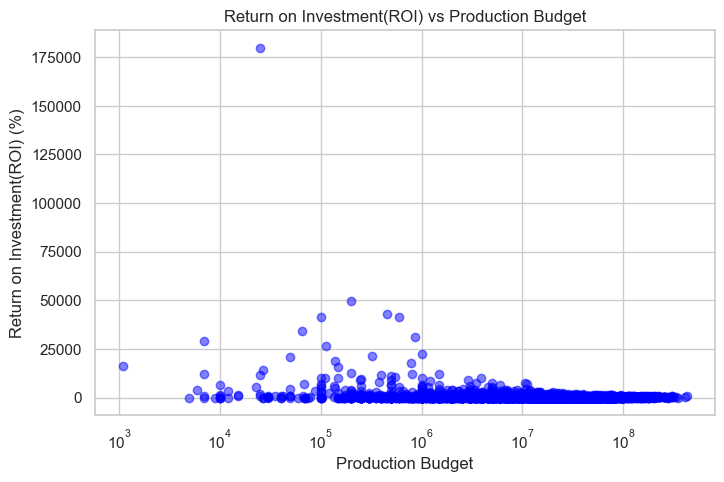

In [120]:
plt.figure(figsize=(8,5))
plt.scatter(tn['production_budget'], tn['Return on Investment(ROI)'], color='blue', alpha=0.5)
plt.xlabel('Production Budget')
plt.ylabel('Return on Investment(ROI) (%)')
plt.title('Return on Investment(ROI) vs Production Budget')
plt.xscale('log')  # Log scale to better visualize wide range budgets
plt.show()

##### Plot Interpretations:
- We used Scatter plot because it is ideal for visualizing relationships between two continuous variables (Production budget and ROI)
- Each dot = 1 movie.
- We used log scale to better visualize wide range budgets (10^(4) = 10,000)

##### Observations:
1. High ROI isn't tied to high budget - The movies with the highest ROI are mostly in the low to mid-budget range (\$10k–\$1M).

2. Big budgets ≠ big ROI - Expensive movies (>\$100M or 10^(8)) tend to have lower ROI, even if they make lots of money because their production costs are huge.

3. Diminishing returns at higher budgets - As budgets grow, ROI tends to flatten. Studios make profits, but the percentage return shrinks.


##### Recomendation

- Consider low to Mid budget movies as they can be highly profitable - These movies are less risky and often perform better per dollar invested. For example  \$1M movie can return 5000% ROI. Avoid avoid mega budgeted movies early on because they don’t guarantee high ROI and they are huge risks because they need global distribution power.


##### Limitation 
Our data doesnt have genres because it would have allowed us to look for genres that thrive on Small Budgets


#### Grouping movies by release_year and production_budget brackets

Created a new column `budget_bracket` by categorizing `production_budget` into labeled bins: <10M, 10M-50M, 50M-200M, and 200M or more (up to max budget).


In [121]:
# Creating budget brackets (bins)
bins = [0, 10_000_000, 50_000_000, 200_000_000, tn['production_budget'].max() + 1]

labels = ['<10M', '10M-50M', '50M-200M', '>200M']

tn['budget_bracket'] = pd.cut(tn['production_budget'], bins=bins, labels=labels, right=False)
tn



,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,profit,Return on Investment(ROI),budget_bracket
0,2009-12-18,Avatar,425000000,760507625,2776345279,2009,2351345279,553.26,>200M
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,635063875,154.67,>200M
2,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019,-200237650,-57.21,>200M
3,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,1072413963,324.38,>200M
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,999721747,315.37,>200M
...,...,...,...,...,...,...,...,...,...
5775,2006-05-26,Cavite,7000,70071,71644,2006,64644,923.49,<10M
5776,2004-12-31,The Mongol King,7000,900,900,2004,-6100,-87.14,<10M
5778,1999-04-02,Following,6000,48482,240495,1999,234495,"3,908.25",<10M
5779,2005-07-13,Return to the Land of Wonders,5000,1338,1338,2005,-3662,-73.24,<10M


##### b) Analyzing average ROI and profit for each budget bracket category.


In [122]:
budget_summary = tn.groupby('budget_bracket')[['Return on Investment(ROI)', 'profit']].mean().reset_index()
budget_summary


C:\Users\user\AppData\Local\Temp\ipykernel_37268\4258284360.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  budget_summary = tn.groupby('budget_bracket')[['Return on Investment(ROI)', 'profit']].mean().reset_index()


,budget_bracket,Return on Investment(ROI),profit
0,<10M,894.37,"14,098,381.77"
1,10M-50M,193.82,"41,407,432.07"
2,50M-200M,171.26,"158,823,993.18"
3,>200M,273.95,"648,035,806.38"


<Figure size 800x500 with 0 Axes>

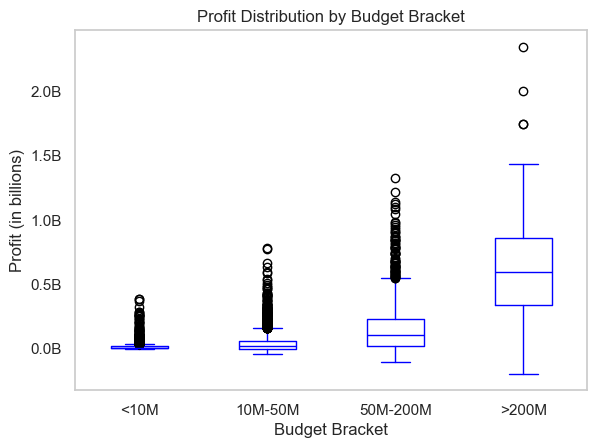

In [123]:
plt.figure(figsize=(8,5))
tn.boxplot(column='profit', by='budget_bracket', grid=False, color='blue')
plt.title('Profit Distribution by Budget Bracket')
plt.suptitle('')
plt.xlabel('Budget Bracket')
plt.ylabel('Profit (in billions)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-9:.1f}B'))
plt.show()


##### Plot Interpretation:
- Boxplots can be used to compare groups thus shows how profit varies across diffrent movie budget bracket brackets. 
- There are many outliers in our data and boxplot shows the outliers clearly which are important for profitability analysis.
- Boxplots show median, spread, and skewnes thus it's easy to feel the spread & risk of our data
- Each Box: 
  - Middle line = median profit.
  - Box edges = 25th and 75th percentiles (interquartile range).
  - Whiskers = range of most data.
  - Dots = outliers (very high profits).

##### Observation
1. <10M Budget Bracket - Suggests Low median and tight spread small movies generally earn small profits.
 - Low median profit.
 - Narrow box and whiskers → low variability.
 - A few outliers with decent profit, but most profits are small.


2. 10M–50M Budget Bracket - Slightly better profit, but still not extreme.
 - Slightly higher median than <10M.
 - Moderate spread.
 - A noticeable number of outliers, suggesting a few highly profitable exceptions.
 

3. 50M–200M Budget Bracket - Suggests a sweet spot where both median profit and upside are attractive, though risk increases (more variability).
 - Higher median profit and wider box (more variability).
 - Many positive outliers (successful movies).


4.>200M Budget Bracket - Indicates high risk, high reward territory (Most profitable bracket) but very wide spread and many outliers (some huge hits, some flops)
 - Highest median profit of all brackets.
 - Very wide spread and tall box (high variability).
 - Many high value outliers (up to 2.3B), but also some low or even negative profits.

##### Recomendation: 
We should target a production budget of possibly between 50-200M range as it balances balances risk and return.
Production budget of more than 200M dominates in average profit, it has the highest upside and variability. Smaller budgeted movies are less risky, they have less variability and fewer outliers 

##### ROI trend over release years

In [124]:
yearly_summary = tn.groupby('release_year')[['Return on Investment(ROI)', 'profit']].mean().reset_index()
yearly_summary

,release_year,Return on Investment(ROI),profit
0,1915,"9,900.00","10,890,000.00"
1,1916,"3,900.00","7,800,000.00"
2,1920,"2,900.00","2,900,000.00"
3,1925,"4,505.18","13,427,500.00"
4,1929,"1,049.87","3,979,000.00"
...,...,...,...
87,2015,361.69,"79,475,952.92"
88,2016,267.79,"97,451,876.18"
89,2017,329.01,"124,338,555.59"
90,2018,303.05,"137,645,677.85"


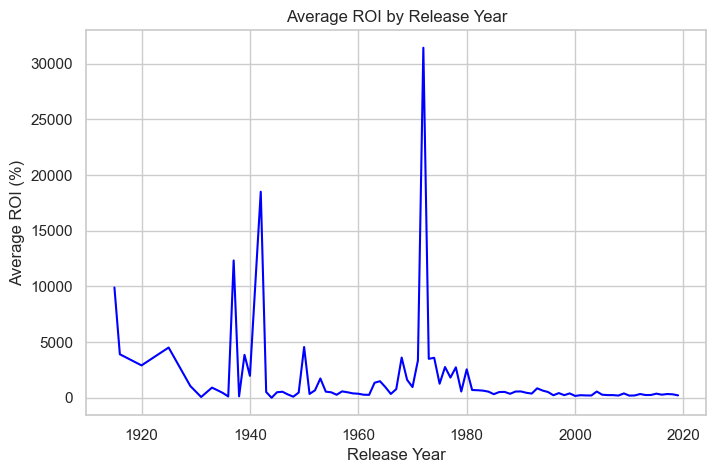

In [125]:
plt.figure(figsize=(8,5))
plt.plot(yearly_summary['release_year'], yearly_summary['Return on Investment(ROI)'], color='blue')
plt.xlabel('Release Year')
plt.ylabel('Average ROI (%)')
plt.title('Average ROI by Release Year')
plt.show()


##### Plot Interpretation:
- To look at how does ROI change over time, and when was investment in movies most efficient? We used time series to track how ROI changes so that it is easy for us to focus on investment performance over the years.


##### Observation:
- Extremely high ROI spikes occur in older movies (like 1930s–1970s), e.g., a peak above 30,000% around 1972.
- After the 1980s, ROI stabilizes and drops to more realistic levels.
- From 1990 onward, average ROI is consistently much lower, usually below 1,000%.


##### Conclusion:
Investment in movies was most efficient in the earlier decades as shown by the significantly higher average ROI compared to more recent years though there may also be fewer records for early years, causing data distortion from a few standout movies. ROI has become more conservative over time.To inspire cost effective production strategies today we could study eras of high return movie models (genres, formats, release strategies or potentially produce remakes of 1930s–1970s era of movies with modern twist


##### Top performers by ROI and profit

In [126]:
# Top 5 movies by ROI
top_roi = tn.sort_values('Return on Investment(ROI)', ascending=False).head(5)[['movie', 'Return on Investment(ROI)', 'profit', 'production_budget']]
print("Top 5 movies by ROI:")
top_roi


Top 5 movies by ROI:


,movie,Return on Investment(ROI),profit,production_budget
5745,Deep Throat,"179,900.00",44975000,25000
5613,Mad Max,"49,775.00",99550000,200000
5492,Paranormal Activity,"43,051.79",193733034,450000
5679,The Gallows,"41,556.47",41556474,100000
5406,The Blair Witch Project,"41,283.33",247700000,600000


In [127]:
# Top 5 movies by profit
top_profit = tn.sort_values('profit', ascending=False).head(5)[['movie', 'profit', 'Return on Investment(ROI)', 'production_budget']]
print("\nTop 5 movies by Profit:")
top_profit


Top 5 movies by Profit:


,movie,profit,Return on Investment(ROI),production_budget
0,Avatar,2351345279,553.26,425000000
42,Titanic,2008208395,"1,004.10",200000000
6,Avengers: Infinity War,1748134200,582.71,300000000
5,Star Wars Ep. VII: The Force Awakens,1747311220,571.02,306000000
33,Jurassic World,1433854864,666.91,215000000


## Regression Modelling

Which production budgets yield the highest return on investment (ROI) in movies?

To explore this, we used ROI as the target variable and production budget as the predictor. We applied a simple linear regression model to examine the relationship and evaluated its performance using R² and Mean Squared Error (MSE).


In [128]:
# Importing libraries
from sklearn.model_selection import train_test_split   # for splitting data into training and testing sets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Defining features (X) and target (y) variables
#'production_budget' as the feature and 'Return on Investment(ROI)' as the target
X = tn[['production_budget']]
y = tn['Return on Investment(ROI)']

# Splitting data into train and test sets (80% for training the model & 20% for testing how well it works)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# metrics to evaluate how well the model performs
print(f"Mean Squared Error: {mse}")    # how far the predictions are from the actual values

print(f"R² Score: {r2}")  # how much of the variation in ROI our model can explain (1 is perfect, 0 is useless)


Mean Squared Error: 3427007.8836275986
R² Score: 0.00691948206586368


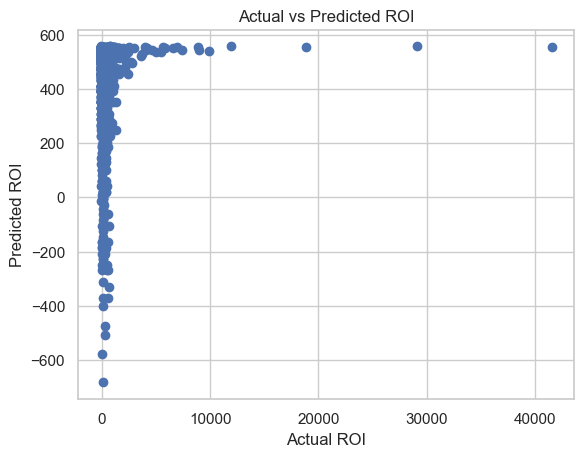

In [129]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual ROI")
plt.ylabel("Predicted ROI")
plt.title("Actual vs Predicted ROI")
plt.grid(True)
plt.show()


The model shows that production budget alone has almost no predictive power for a movie’s ROI (R² = 0.0069), meaning we can’t reliably estimate profitability just from how much was spent on production. This weak relationship highlights a key limitation: production budgets typically exclude other critical financial factors such as marketing expenses, cinema or streaming platform cuts, and backend deals. Simply spending more on production doesn’t guarantee higher returns. To make better predictions, we would likely need a broader range of data that captures the full financial picture of a movie’s lifecycle.

## Market Analysis

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
data = pd.read_csv("Data/bom.movie_gross.csv")
data

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,"415,000,000.00",652000000,2010
1,Alice in Wonderland (2010),BV,"334,200,000.00",691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,"296,000,000.00",664300000,2010
3,Inception,WB,"292,600,000.00",535700000,2010
4,Shrek Forever After,P/DW,"238,700,000.00",513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,"6,200.00",NaN,2018
3383,Edward II (2018 re-release),FM,"4,800.00",NaN,2018
3384,El Pacto,Sony,"2,500.00",NaN,2018
3385,The Swan,Synergetic,"2,400.00",NaN,2018


In [132]:
data.shape

(3387, 5)

In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [134]:
data["foreign_gross"]=data["foreign_gross"].fillna(0)
data

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,"415,000,000.00",652000000,2010
1,Alice in Wonderland (2010),BV,"334,200,000.00",691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,"296,000,000.00",664300000,2010
3,Inception,WB,"292,600,000.00",535700000,2010
4,Shrek Forever After,P/DW,"238,700,000.00",513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,"6,200.00",0,2018
3383,Edward II (2018 re-release),FM,"4,800.00",0,2018
3384,El Pacto,Sony,"2,500.00",0,2018
3385,The Swan,Synergetic,"2,400.00",0,2018


In [135]:
# Remove $ and commas from 'domestic_gross' and 'foreign_gross', then convert to numeric
data['foreign_gross'] = (
    data['foreign_gross']
    .replace('[\$,]', '', regex=True)
    .astype(float)
)

<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
C:\Users\user\AppData\Local\Temp\ipykernel_37268\3217989167.py:4: SyntaxWarning: invalid escape sequence '\$'
  .replace('[\$,]', '', regex=True)


In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   3387 non-null   float64
 4   year            3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


In [137]:
# Create total gross column
data['total_gross'] = data['domestic_gross'] + data['foreign_gross']

In [138]:
#Group by studio and sum total_gross
studio_revenue = (
    data.groupby('studio')['total_gross']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)
#studio_revenue['total_gross'] = studio_revenue['total_gross'].apply(lambda x: f"{int(x):,}")
studio_revenue

,studio,total_gross
0,BV,"44,212,883,899.10"
1,Fox,"31,005,366,596.00"
2,WB,"30,835,948,998.00"
3,Uni.,"29,757,164,191.40"
4,Sony,"22,404,919,096.00"
5,Par.,"19,549,255,697.00"
6,WB (NL),"10,334,699,999.00"
7,LGF,"8,594,582,700.00"
8,LG/S,"5,431,923,998.00"
9,P/DW,"5,076,500,000.00"


C:\Users\user\AppData\Local\Temp\ipykernel_37268\152590726.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=studio_revenue, x='studio', y='total_gross', palette='rocket')


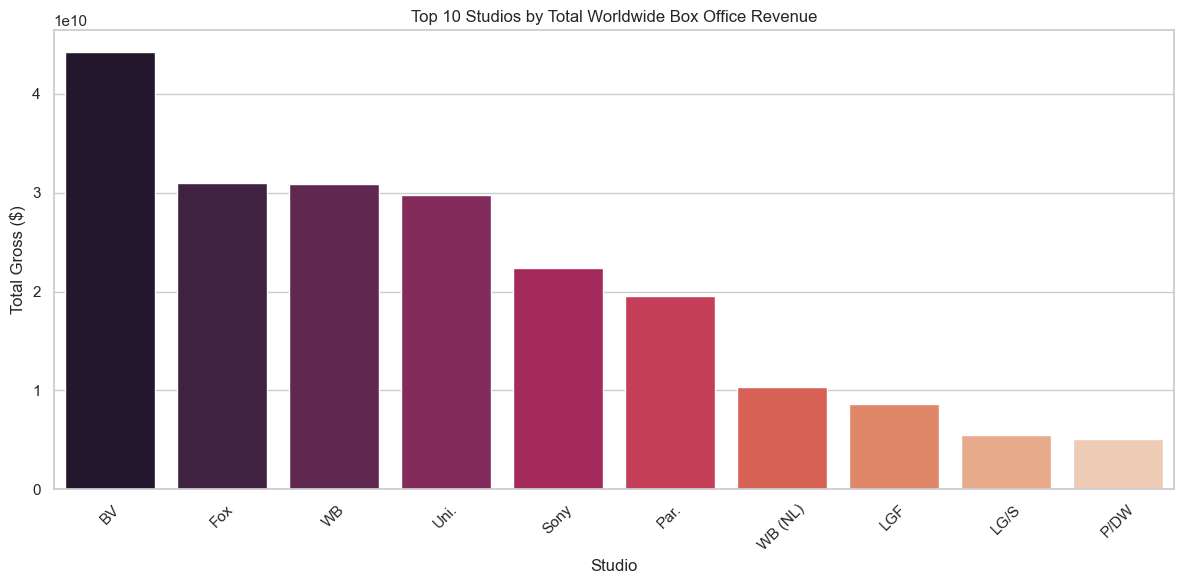

In [139]:
plt.figure(figsize=(12,6))
sns.barplot(data=studio_revenue, x='studio', y='total_gross', palette='rocket')
plt.title('Top 10 Studios by Total Worldwide Box Office Revenue')
plt.ylabel('Total Gross ($)')
plt.xlabel('Studio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [140]:
data["year"].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [141]:
gross_by_year = data.groupby('year')['total_gross'].sum().reset_index()
gross_by_year

,year,total_gross
0,2010,"24,529,597,497.00"
1,2011,"25,730,325,196.00"
2,2012,"27,879,590,994.00"
3,2013,"27,372,572,195.00"
4,2014,"27,294,406,197.00"
5,2015,"26,205,761,807.00"
6,2016,"30,235,042,397.00"
7,2017,"30,862,199,205.00"
8,2018,"28,565,700,468.50"


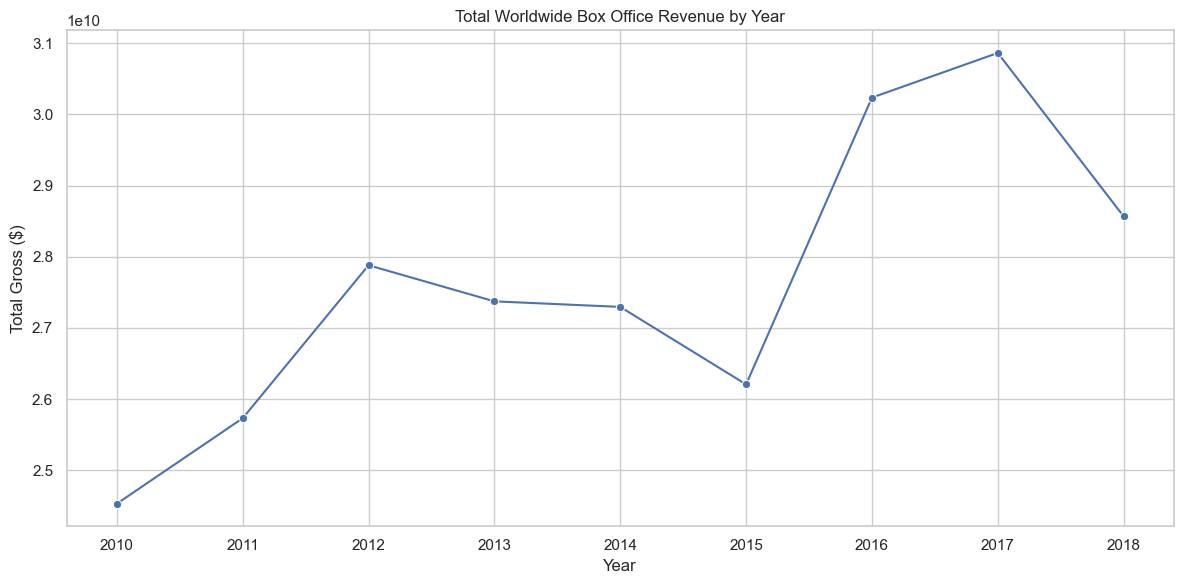

In [142]:


plt.figure(figsize=(12, 6))
sns.lineplot(data=gross_by_year, x='year', y='total_gross', marker='o')
plt.title("Total Worldwide Box Office Revenue by Year")
plt.xlabel("Year")
plt.ylabel("Total Gross ($)")
plt.tight_layout()
plt.show()

## Exploring Movie Success Factors: 
- Genre
- Ratings
- Revenue
- Votes

In [143]:
dt = pd.read_csv("Data/rt.movie_info.tsv", sep='\t')
dt.head(2)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One


In [144]:
dt.shape

(1560, 12)

In [145]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [146]:
# Clean box_office column
dt['box_office'] = pd.to_numeric(dt['box_office'].str.replace('[\$,]', '', regex=True), errors='coerce')

# Convert runtime to integer minutes (assuming format like '120 min')
dt['runtime'] = dt['runtime'].str.extract('(\d+)').astype(float)

# Convert theater_date to datetime and extract year from date
dt['theater_date'] = pd.to_datetime(dt['theater_date'], errors='coerce')
dt['year'] = dt['theater_date'].dt.year


<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_37268\2411784885.py:2: SyntaxWarning: invalid escape sequence '\$'
  dt['box_office'] = pd.to_numeric(dt['box_office'].str.replace('[\$,]', '', regex=True), errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_37268\2411784885.py:5: SyntaxWarning: invalid escape sequence '\d'
  dt['runtime'] = dt['runtime'].str.extract('(\d+)').astype(float)


In [147]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            1560 non-null   int64         
 1   synopsis      1498 non-null   object        
 2   rating        1557 non-null   object        
 3   genre         1552 non-null   object        
 4   director      1361 non-null   object        
 5   writer        1111 non-null   object        
 6   theater_date  1201 non-null   datetime64[ns]
 7   dvd_date      1201 non-null   object        
 8   currency      340 non-null    object        
 9   box_office    340 non-null    float64       
 10  runtime       1530 non-null   float64       
 11  studio        494 non-null    object        
 12  year          1201 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(8)
memory usage: 158.6+ KB


In [148]:
#counting the values of genre
genre_counts = dt['genre'].value_counts().head(10)
genre_counts 

genre
Drama                                              151
Comedy                                             110
Comedy|Drama                                        80
Drama|Mystery and Suspense                          67
Art House and International|Drama                   62
Action and Adventure|Drama                          42
Action and Adventure|Drama|Mystery and Suspense     40
Drama|Romance                                       35
Comedy|Romance                                      32
Art House and International|Comedy|Drama            31
Name: count, dtype: int64

C:\Users\user\AppData\Local\Temp\ipykernel_37268\2763916264.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


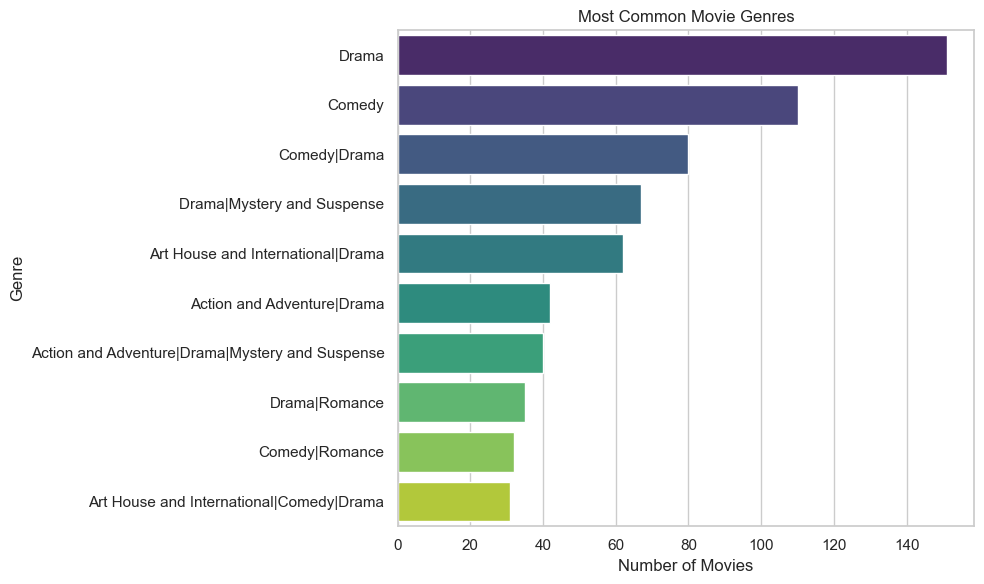

In [149]:
#plotting the genre and counts
plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Most Common Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

In [150]:
#counting the ratings
rating_counts = dt['rating'].value_counts()
rating_counts

rating
R        521
NR       503
PG       240
PG-13    235
G         57
NC17       1
Name: count, dtype: int64

C:\Users\user\AppData\Local\Temp\ipykernel_37268\244050860.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='pastel')


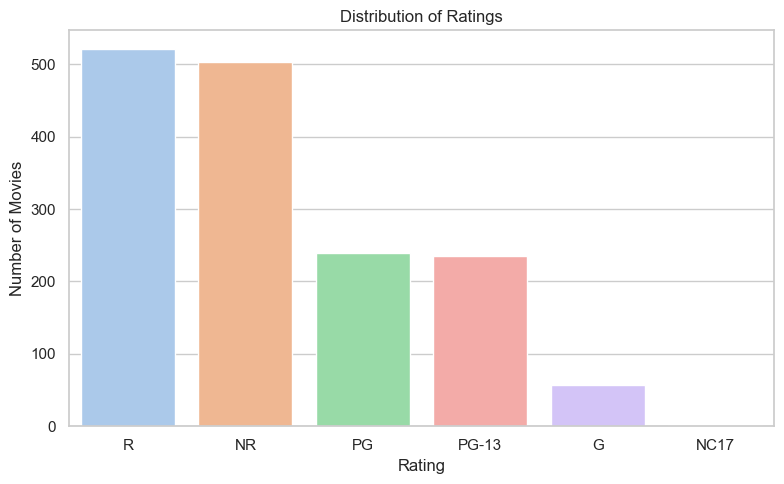

In [151]:
#Plotting the ratings with counts
plt.figure(figsize=(8,5))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='pastel')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

In [152]:
# Summary Runtime Stats by Rating
rating_runtime_stats = dt.groupby('rating')['runtime'].agg(['count', 'mean', 'median', 'std']).sort_values(by='mean', ascending=False)
rating_runtime_stats

,count,mean,median,std
rating,,,,
PG-13,232,107.38,106.00,18.47
R,519,106.57,103.00,20.98
PG,239,104.75,100.00,18.30
NR,482,99.89,95.00,31.86
G,57,97.91,95.00,25.74
NC17,1,89.00,89.00,NaN


In [153]:
#Compute Mean Runtime per Rating
mean_runtimes = (
    dt.groupby('rating')['runtime']
    .mean()
    .dropna()
    .sort_values(ascending=False)
    .reset_index()
)

C:\Users\user\AppData\Local\Temp\ipykernel_37268\4188268281.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_runtimes, x='rating', y='runtime', palette='coolwarm')


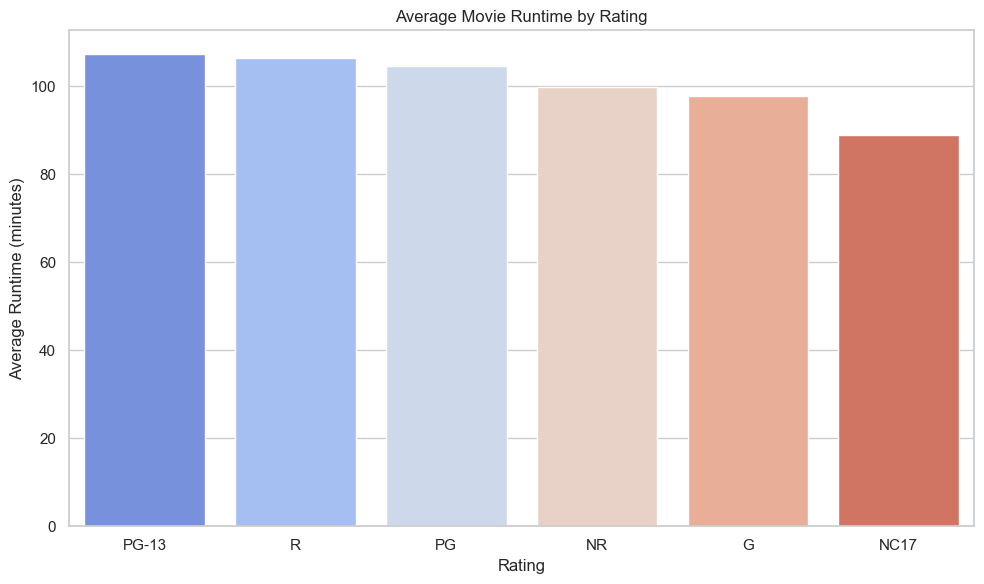

In [154]:
#Plotting Bar Chart of the ratings and mean runtime
plt.figure(figsize=(10,6))
sns.barplot(data=mean_runtimes, x='rating', y='runtime', palette='coolwarm')
plt.title('Average Movie Runtime by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Runtime (minutes)')
plt.tight_layout()
plt.show()

In [155]:
# Drop missing directors and do counts
top_directors = (
    dt['director']
    .dropna()
    .value_counts()
    .head(10)
    .reset_index()
)
# Rename columns for clarity
top_directors.columns = ['director', 'movie_count']
top_directors

,director,movie_count
0,Steven Spielberg,10
1,Clint Eastwood,8
2,William Beaudine,4
3,Bruce Beresford,4
4,Curtis Hanson,4
5,Ridley Scott,4
6,Alfred Hitchcock,4
7,Jim Jarmusch,4
8,Barry Levinson,4
9,William Friedkin,4


C:\Users\user\AppData\Local\Temp\ipykernel_37268\1687934256.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_directors, x='movie_count', y='director', palette='mako')


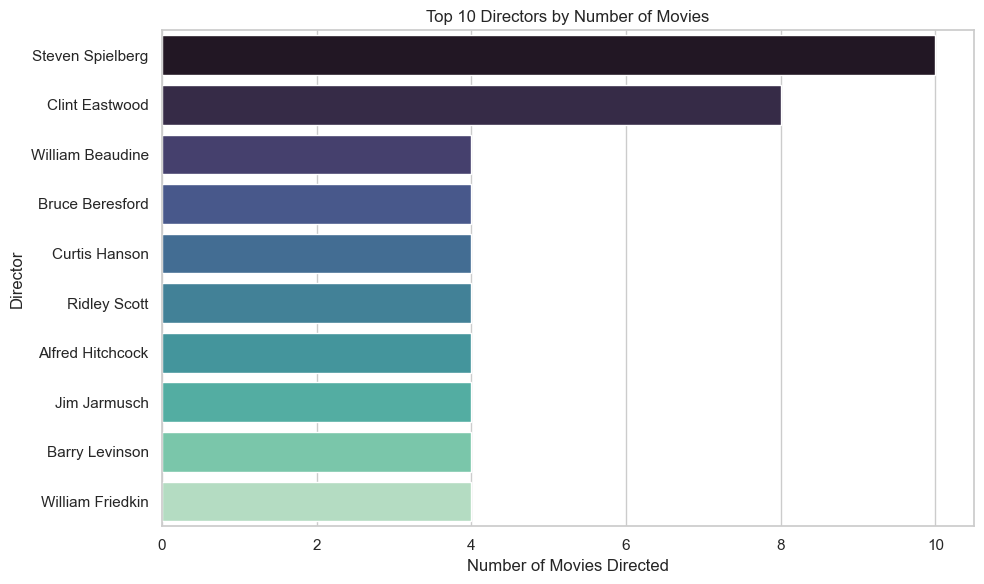

In [156]:
#plot
plt.figure(figsize=(10,6))
sns.barplot(data=top_directors, x='movie_count', y='director', palette='mako')
plt.title('Top 10 Directors by Number of Movies')
plt.xlabel('Number of Movies Directed')
plt.ylabel('Director')
plt.tight_layout()
plt.show()

In [157]:
# Drop missing writers and count occurrences
top_writers = (
    dt['writer']
    .dropna()
    .value_counts()
    .head(10)
    .reset_index()
)

# Rename columns for clarity
top_writers.columns = ['writer', 'movie_count']
top_writers

,writer,movie_count
0,Woody Allen,4
1,Hong Sang-soo,3
2,John Hughes,3
3,Sylvester Stallone,3
4,Jim Jarmusch,3
5,Peter Morgan,2
6,Steven Zaillian,2
7,Mike White,2
8,Daniel Taplitz,2
9,Seth MacFarlane|Alec Sulkin|Wellesley Wild,2


C:\Users\user\AppData\Local\Temp\ipykernel_37268\4187828141.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_writers, x='movie_count', y='writer', palette='crest')


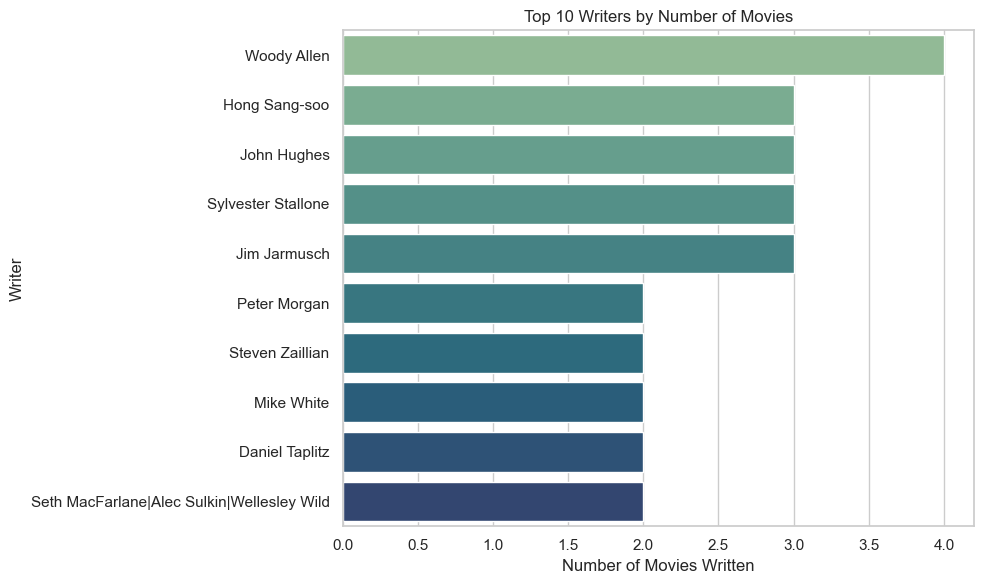

In [158]:
#Plot
plt.figure(figsize=(10,6))
sns.barplot(data=top_writers, x='movie_count', y='writer', palette='crest')
plt.title('Top 10 Writers by Number of Movies')
plt.xlabel('Number of Movies Written')
plt.ylabel('Writer')
plt.tight_layout()
plt.show()

What Drives Movie Popularity? 
- Ratings
- Genres
- Votes

In [159]:
#Load the data set
df = pd.read_csv("Data/tmdb.movies.csv")
df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.53,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.70,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.73,2010-03-26,How to Train Your Dragon,7.70,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.52,2010-05-07,Iron Man 2,6.80,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.00,1995-11-22,Toy Story,7.90,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.92,2010-07-16,Inception,8.30,22186


In [160]:
#Displays the number of rows and columns
print("Dataset shape:", df.shape)

Dataset shape: (26517, 10)


In [161]:
# Quick summary of data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [162]:
# Convert release_date to datetime object
#This allows us to analyze trends by year/month and sort by release date.
df["release_date"] = pd.to_datetime(df["release_date"], format="%d-%m-%y", errors="coerce")
#errors="coerce" will set invalid dates to NaT (missing) so they don't crash our code.


In [163]:
#Create a genre ID to name map

genre_map = {
    28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy',
    80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family',
    14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music',
    9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction',
    10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'
}


In [164]:
# Convert genre_ids string to list, then map to genre names
df["genres"] = df["genre_ids"].apply(lambda x: [genre_map.get(i, "Unknown") for i in ast.literal_eval(x)])


In [165]:

# Check for missing values in each column
print(" Missing values:\n", df.isnull().sum())

# Exclude the 'genres' column (contains unhashable lists) when checking for duplicates
df_no_list = df.drop(columns=["genres"])

# Check for duplicate rows (excluding unhashable list columns)
duplicate_count = df_no_list.duplicated().sum()
print(f" Duplicate rows: {duplicate_count}")

# Drop duplicate rows based on id, title, and release_date (common unique identifiers)
df = df.drop_duplicates(subset=["id", "title", "release_date"])

# Reset index after dropping
df.reset_index(drop=True, inplace=True)


 Missing values:
 Unnamed: 0               0
genre_ids                0
id                       0
original_language        0
original_title           0
popularity               0
release_date         26517
title                    0
vote_average             0
vote_count               0
genres                   0
dtype: int64
 Duplicate rows: 0


In [166]:
#Final Check (Print Cleaned Sample)
df_cleaned = df[["title", "genres","id","popularity", "vote_average", "vote_count", "release_date"]]

df_cleaned.head()

,title,genres,id,popularity,vote_average,vote_count,release_date
0,Harry Potter and the Deathly Hallows: Part 1,"[Adventure, Fantasy, Family]",12444,33.53,7.70,10788,NaT
1,How to Train Your Dragon,"[Fantasy, Adventure, Animation, Family]",10191,28.73,7.70,7610,NaT
2,Iron Man 2,"[Adventure, Action, Science Fiction]",10138,28.52,6.80,12368,NaT
3,Toy Story,"[Animation, Comedy, Family]",862,28.00,7.90,10174,NaT
4,Inception,"[Action, Science Fiction, Adventure]",27205,27.92,8.30,22186,NaT


In [167]:
#Identify which genres are most commonly associated with high popularity and strong audience ratings.
## Step 1: Explode genres to separate rows
df_exploded = df_cleaned.explode('genres')

# Ensure df_cleaned is a true copy
df_cleaned = df_cleaned.copy()

# Step 2: Group and aggregate
genre_stats = df_exploded.groupby('genres').agg({
    'popularity': 'mean',
    'vote_average': 'mean',
    'title': 'count'  # Movie count per genre
}).rename(columns={'title': 'movie_count'}).reset_index()

# Step 3: Sort by popularity (optional)
genre_stats = genre_stats.sort_values(by='popularity', ascending=False)

# Preview result
print(genre_stats.head())


       genres  popularity  vote_average  movie_count
1   Adventure        7.32          5.90         1334
0      Action        6.34          5.57         2534
8     Fantasy        6.18          5.91         1082
4       Crime        5.34          5.83         1426
17        War        5.14          6.22          318


C:\Users\user\AppData\Local\Temp\ipykernel_37268\3640782020.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_stats, x='popularity', y='genres', palette='viridis')


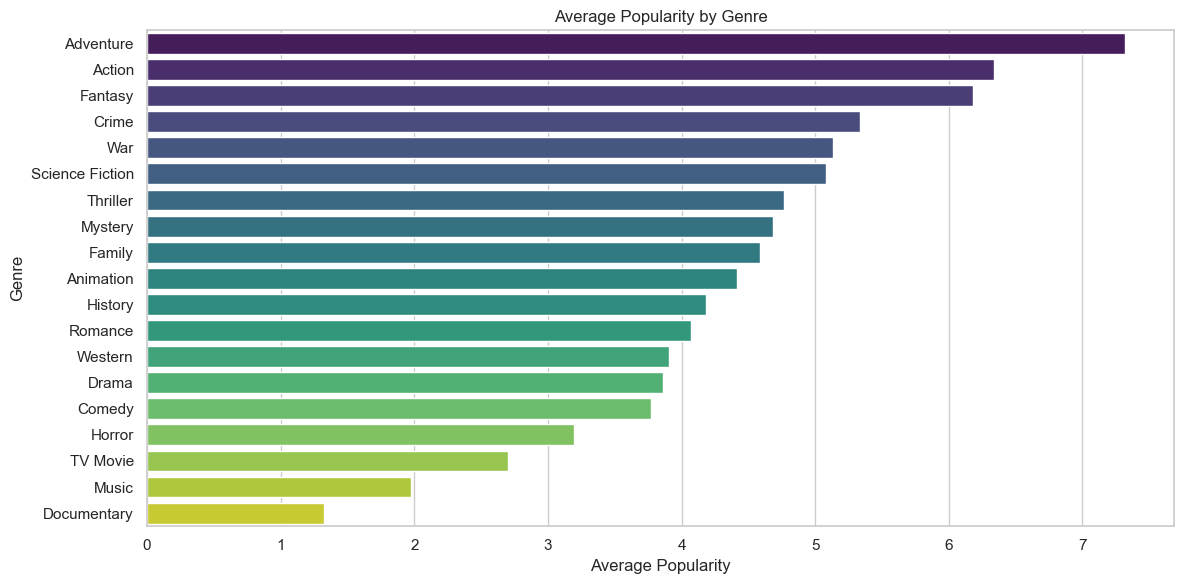

In [168]:
## Barplot: Average popularity per genre
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_stats, x='popularity', y='genres', palette='viridis')
plt.title('Average Popularity by Genre')
plt.xlabel('Average Popularity')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

Top Performing Genres (based on average statistics):

Action: High popularity, moderate ratings (large audience but some mixed reception).

Fantasy: Very high popularity and generally good ratings (attracts both mainstream and dedicated audiences).

Drama: Strong ratings but lower popularity compared to Action/Fantasy.

Animation: Very high ratings with moderate popularity — beloved by families and audiences seeking quality storytelling.

By focusing on these top-performing genres, studios can optimize their content portfolio to maximize both audience engagement (popularity) and viewer satisfaction (ratings), ensuring both financial returns and critical acclaim.

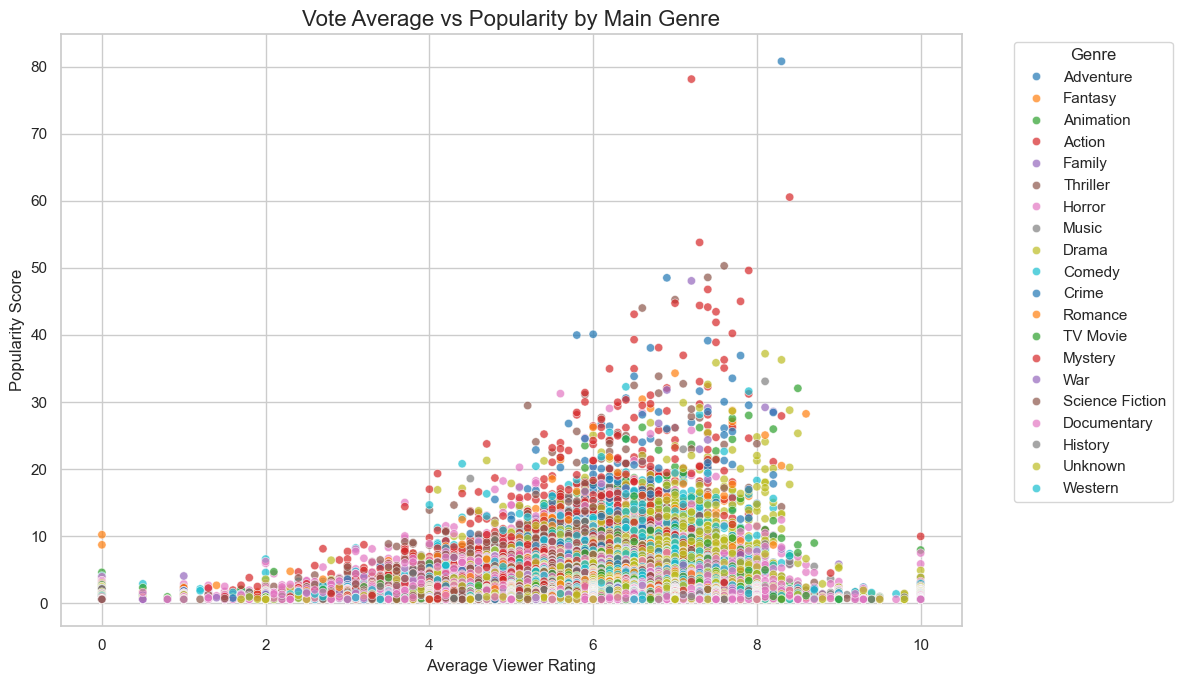

In [169]:
#The relationship between vote_average (viewer reception) and popularity
# Create a simplified genre column with the first genre only
df_cleaned["main_genre"] = df_cleaned["genres"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else "Unknown")

# Ensure df_cleaned is a true copy
df_cleaned = df_cleaned.copy()

# Set plot size and style
plt.figure(figsize=(12, 7))
sns.set(style="whitegrid")

# Scatter plot
sns.scatterplot(
    data=df_cleaned,
    x="vote_average",
    y="popularity",
    hue="main_genre",
    alpha=0.7,
    palette="tab10"
)

# Titles and labels
plt.title("Vote Average vs Popularity by Main Genre", fontsize=16)
plt.xlabel("Average Viewer Rating", fontsize=12)
plt.ylabel("Popularity Score", fontsize=12)
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Popularity vs Ratings: From the chart we can seeviewer ratings of 6 and above indicate high popularity in the movies.Popular action movies may bring in a large audience for their flashy effects and colorful explosions, but those movies end up having mixed or average reviews.  

Drama, Animation and Family genres have gentler extremes, whereas Action, Sci-Fi, and Adventure tend to be more polarized with their reception. Because of differing audience expectations, some are likely to love them, and some will definitely hate them.  

When planning movies, especially for large scale blockbusters versus small scale niche movies, studios must consider the possible popularity level and how the audience will receive it.



The majority of movies seem to have low-to-moderate engagement (around 100 to 1,000 votes). This could be due to independent or niche movies that don't reach mass audiences.

The long tail of high vote counts is an indicator of a few blockbusters or popular movies that generate significant attention (e.g., Avengers, Harry Potter, etc.).

Actionable Insights:

Studios aiming for broader audience engagement might want to focus on genres that have a higher likelihood of generating high vote counts. Typically, action, adventure, and sci-fi genres see more engagement.

Targeting niche genres with consistent moderate engagement may be a way to ensure sustained, smaller but loyal audiences.

C:\Users\user\AppData\Local\Temp\ipykernel_37268\1753438495.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


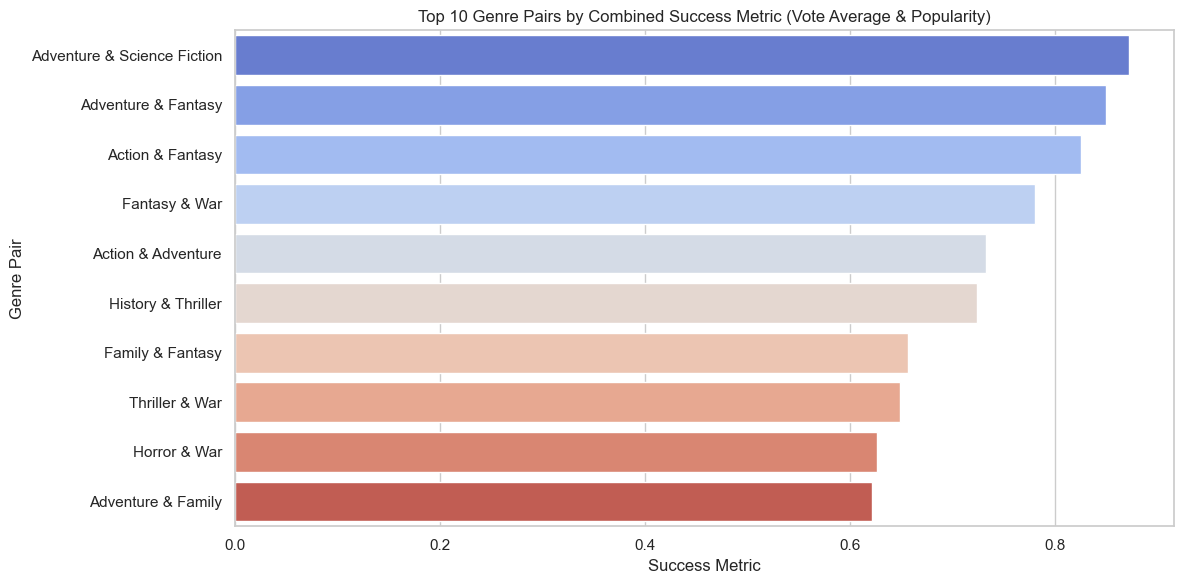

🔢 Summary of Top Genre Pairs by Combined Success Metric:

                      genre_pairs  vote_average  popularity  success_metric  \
30   (Adventure, Science Fiction)          5.87       10.89            0.87   
24           (Adventure, Fantasy)          6.01       10.69            0.85   
7               (Action, Fantasy)          5.62       10.65            0.83   
124                (Fantasy, War)          6.01        9.59            0.78   
0             (Action, Adventure)          5.65        9.39            0.73   
132           (History, Thriller)          6.50        8.66            0.72   
105             (Family, Fantasy)          6.21        8.11            0.66   
168               (Thriller, War)          6.10        7.97            0.65   
141                 (Horror, War)          5.73        7.96            0.63   
23            (Adventure, Family)          6.05        7.84            0.62   

     movie_count  
30           259  
24           304  
7            22

In [170]:
#Top 10 Genre Pairs by Combined Success Metric (Vote Average & Popularity)
# Generate all unique genre pairs
df_cleaned['genre_pairs'] = df_cleaned['genres'].apply(lambda x: list(combinations(sorted(set(x)), 2)))

# Explode rows for each pair (flatten genre pairs)
df_exploded = df_cleaned.explode('genre_pairs')

# Calculate a success metric based on vote_average and popularity
# Normalize the popularity to balance the weight of both metrics
max_popularity = df_exploded['popularity'].max()
df_exploded['success_metric'] = (df_exploded['vote_average'] * df_exploded['popularity']) / max_popularity

# Group by genre pair and aggregate
genre_pair_stats = df_exploded.groupby('genre_pairs').agg({
    'vote_average': 'mean',
    'popularity': 'mean',
    'success_metric': 'mean',
    'title': 'count'
}).rename(columns={'title': 'movie_count'}).reset_index()

# Filter to genre pairs with at least 2 movies (for better reliability)
genre_pair_stats = genre_pair_stats[genre_pair_stats['movie_count'] >= 2]

# Sort by success_metric and pick the top 10 pairs
top_pairs = genre_pair_stats.sort_values(by='success_metric', ascending=False).head(10)

# Plotting top 10 genre pairs by success metric
plt.figure(figsize=(12, 6))
sns.barplot(
    x='success_metric',
    y=top_pairs['genre_pairs'].apply(lambda x: f"{x[0]} & {x[1]}"),
    palette='coolwarm',
    data=top_pairs
)
plt.title("Top 10 Genre Pairs by Combined Success Metric (Vote Average & Popularity)")
plt.xlabel("Success Metric")
plt.ylabel("Genre Pair")
plt.tight_layout()
plt.show()

# Print summary stats
print("🔢 Summary of Top Genre Pairs by Combined Success Metric:\n")
print(top_pairs[['genre_pairs', 'vote_average', 'popularity', 'success_metric', 'movie_count']])

- Top Performer: Adventure & Science Fiction is the top combo with a success metric of 8.7
- Adventure & Fantasy (8.5), Strong contender with excellent audience approval and reach.This genre pair works well for epic journeys, mythical stories, or fantasy worlds — think Harry Potter or Lord of the Rings.
- Some genre pairs like Action & Thriller have decent popularity but relatively lower vote_average.

In [171]:
#Calculating correlation using popularity,vote_average and vote_count.

# Explode genres so each row has one genre per movie
df_exploded = df.explode('genres')

# One-hot encode genres
genre_dummies = pd.get_dummies(df_exploded['genres'])

# Combine encoded genres with popularity, vote_average, and vote_count
combined = pd.concat([df_exploded[['popularity', 'vote_average', 'vote_count']], genre_dummies], axis=1)

# Calculate correlation between each genre and success metrics
correlation_matrix = combined.corr().loc[['popularity', 'vote_average', 'vote_count'], genre_dummies.columns]

# Transpose to make it easier to read
correlation_by_genre = correlation_matrix.T.sort_values(by='popularity', ascending=False)

# Display top genres most positively correlated with each metric
print(correlation_by_genre.head(10))

                 popularity  vote_average  vote_count
Action                 0.12         -0.05        0.08
Adventure              0.12         -0.00        0.12
Fantasy                0.07         -0.00        0.06
Thriller               0.06         -0.10        0.01
Crime                  0.05         -0.01        0.02
Science Fiction        0.05         -0.06        0.06
Family                 0.03          0.00        0.01
Mystery                0.03         -0.02        0.01
War                    0.02          0.01        0.01
Animation              0.02          0.05        0.00


 Insight:
- If the studio wants high popularity and engagement, focus on Action, Adventure, or Sci-Fi.
- If aiming for high ratings, Documentary and History genres show stronger positive correlations.

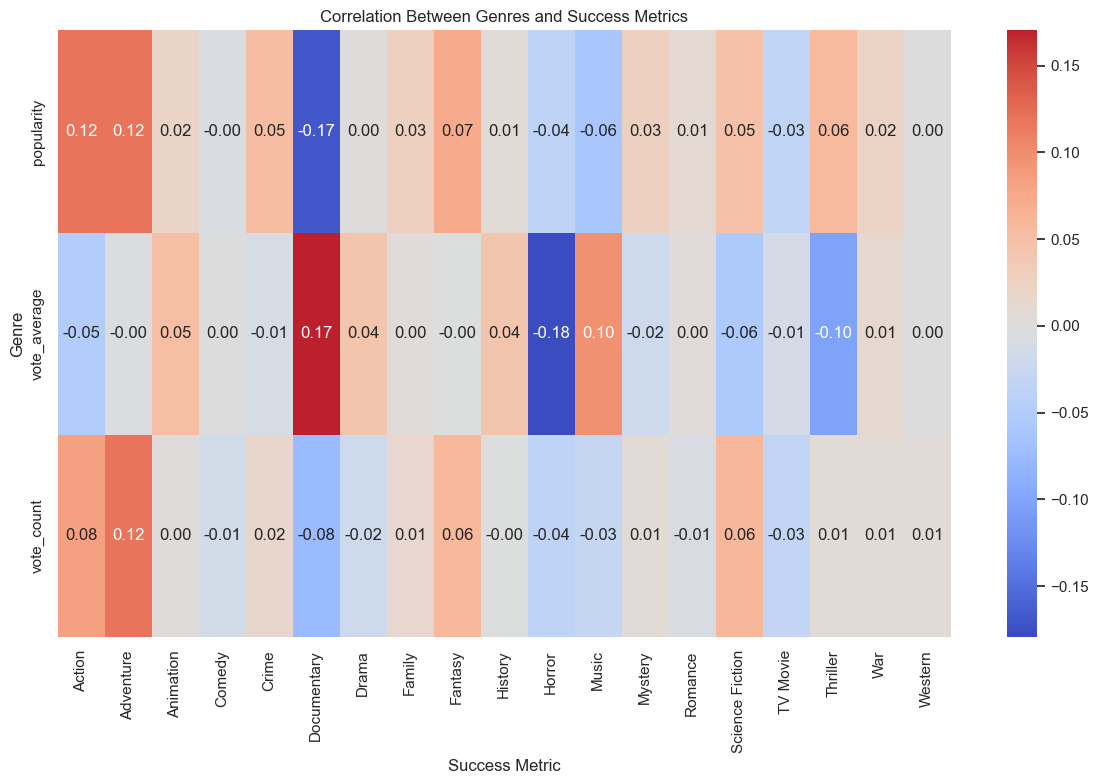

In [172]:
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Between Genres and Success Metrics')
plt.xlabel('Success Metric')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

Brighter red cells: Strong positive correlation

Brighter blue cells: Strong negative correlation

How to Interpret
Genres with high values in “popularity” column: More likely to attract large audiences.

Genres with high “vote_average”: Likely critically acclaimed.

Genres with high “vote_count”: Receive more viewer engagement or mainstream appeal.

## IMDB - Internet Movie Database

In [173]:
import sqlite3

In [174]:
con = sqlite3.connect("data/im.db")

In [175]:
cursor = con.cursor()

In [176]:
schema_df = pd.read_sql("""
SELECT *
FROM sqlite_master
WHERE type='table'
""",con)

schema_df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [177]:
# Movie bascic information

print(schema_df['sql'].iloc[0])

CREATE TABLE "movie_basics" (
"movie_id" TEXT,
  "primary_title" TEXT,
  "original_title" TEXT,
  "start_year" INTEGER,
  "runtime_minutes" REAL,
  "genres" TEXT
)


In [178]:
pd.read_sql("""
SELECT *
FROM movie_basics
LIMIT 10
""",con)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.00,Comedy
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller"
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.00,"Adventure,Animation,Comedy"
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History"
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.00,Biography


In [179]:
print(schema_df['sql'].iloc[1])

CREATE TABLE "directors" (
"movie_id" TEXT,
  "person_id" TEXT
)


In [180]:
pd.read_sql("""
SELECT *
FROM directors
LIMIT 10
""",con)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
5,tt0878654,nm2291498
6,tt0878654,nm2292011
7,tt0879859,nm2416460
8,tt0996958,nm2286991
9,tt0996958,nm2286991


In [181]:
print(schema_df['sql'].iloc[2])

CREATE TABLE "known_for" (
"person_id" TEXT,
  "movie_id" TEXT
)


In [182]:
pd.read_sql("""
SELECT *
FROM known_for
LIMIT 10
 """,con)

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471
3,nm0061671,tt0118553
4,nm0061865,tt0896534
5,nm0061865,tt6791238
6,nm0061865,tt0287072
7,nm0061865,tt1682940
8,nm0062070,tt1470654
9,nm0062070,tt0363631


In [183]:
print(schema_df['sql'].iloc[3])

CREATE TABLE "movie_akas" (
"movie_id" TEXT,
  "ordering" INTEGER,
  "title" TEXT,
  "region" TEXT,
  "language" TEXT,
  "types" TEXT,
  "attributes" TEXT,
  "is_original_title" REAL
)


In [184]:
pd.read_sql("""
SELECT *
FROM movie_akas
LIMIT 10
""",con)

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.00
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.00
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.00
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.00
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.00
5,tt0369610,15,Jurassic World,GR,None,imdbDisplay,None,0.00
6,tt0369610,16,Jurassic World,IT,None,imdbDisplay,None,0.00
7,tt0369610,17,Jurski svijet,HR,None,imdbDisplay,None,0.00
8,tt0369610,18,Olam ha'Yura,IL,he,imdbDisplay,None,0.00
9,tt0369610,19,Jurassic World: Mundo Jurásico,MX,None,imdbDisplay,None,0.00


In [185]:
print(schema_df['sql'].iloc[4])

CREATE TABLE "movie_ratings" (
"movie_id" TEXT,
  "averagerating" REAL,
  "numvotes" INTEGER
)


In [186]:
pd.read_sql("""
SELECT *
FROM movie_ratings
LIMIT 10
""",con)

,movie_id,averagerating,numvotes
0,tt10356526,8.30,31
1,tt10384606,8.90,559
2,tt1042974,6.40,20
3,tt1043726,4.20,50352
4,tt1060240,6.50,21
5,tt1069246,6.20,326
6,tt1094666,7.00,1613
7,tt1130982,6.40,571
8,tt1156528,7.20,265
9,tt1161457,4.20,148


In [187]:
print(schema_df['sql'].iloc[5])

CREATE TABLE "persons" (
"person_id" TEXT,
  "primary_name" TEXT,
  "birth_year" REAL,
  "death_year" REAL,
  "primary_profession" TEXT
)


In [188]:
pd.read_sql("""
SELECT *
FROM persons
LIMIT 10
""",con)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,None,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,None,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,None,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,None,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,None,"production_designer,art_department,set_decorator"
5,nm0062879,Ruel S. Bayani,NaN,None,"director,production_manager,miscellaneous"
6,nm0063198,Bayou,NaN,None,actor
7,nm0063432,Stevie Be-Zet,NaN,None,"composer,soundtrack"
8,nm0063618,Jeff Beal,"1,963.00",None,"composer,music_department,soundtrack"
9,nm0063750,Lindsay Beamish,NaN,None,"actress,miscellaneous"


In [189]:
print(schema_df['sql'].iloc[6])

CREATE TABLE "principals" (
"movie_id" TEXT,
  "ordering" INTEGER,
  "person_id" TEXT,
  "category" TEXT,
  "job" TEXT,
  "characters" TEXT
)


In [190]:
pd.read_sql("""
SELECT *
FROM principals 
LIMIT 10
""",con)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"
5,tt0323808,2,nm2694680,actor,None,"[""Steve Thomson""]"
6,tt0323808,3,nm0574615,actor,None,"[""Sir Lachlan Morrison""]"
7,tt0323808,4,nm0502652,actress,None,"[""Lady Delia Morrison""]"
8,tt0323808,5,nm0362736,director,None,None
9,tt0323808,6,nm0811056,producer,producer,None


In [191]:
print(schema_df['sql'].iloc[7])

CREATE TABLE "writers" (
"movie_id" TEXT,
  "person_id" TEXT
)


In [192]:
pd.read_sql("""
SELECT *
FROM writers
LIMIT 10
""",con)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087
5,tt0835418,nm0841532
6,tt0878654,nm0284943
7,tt0878654,nm0284943
8,tt0878654,nm0284943
9,tt0996958,nm2286991


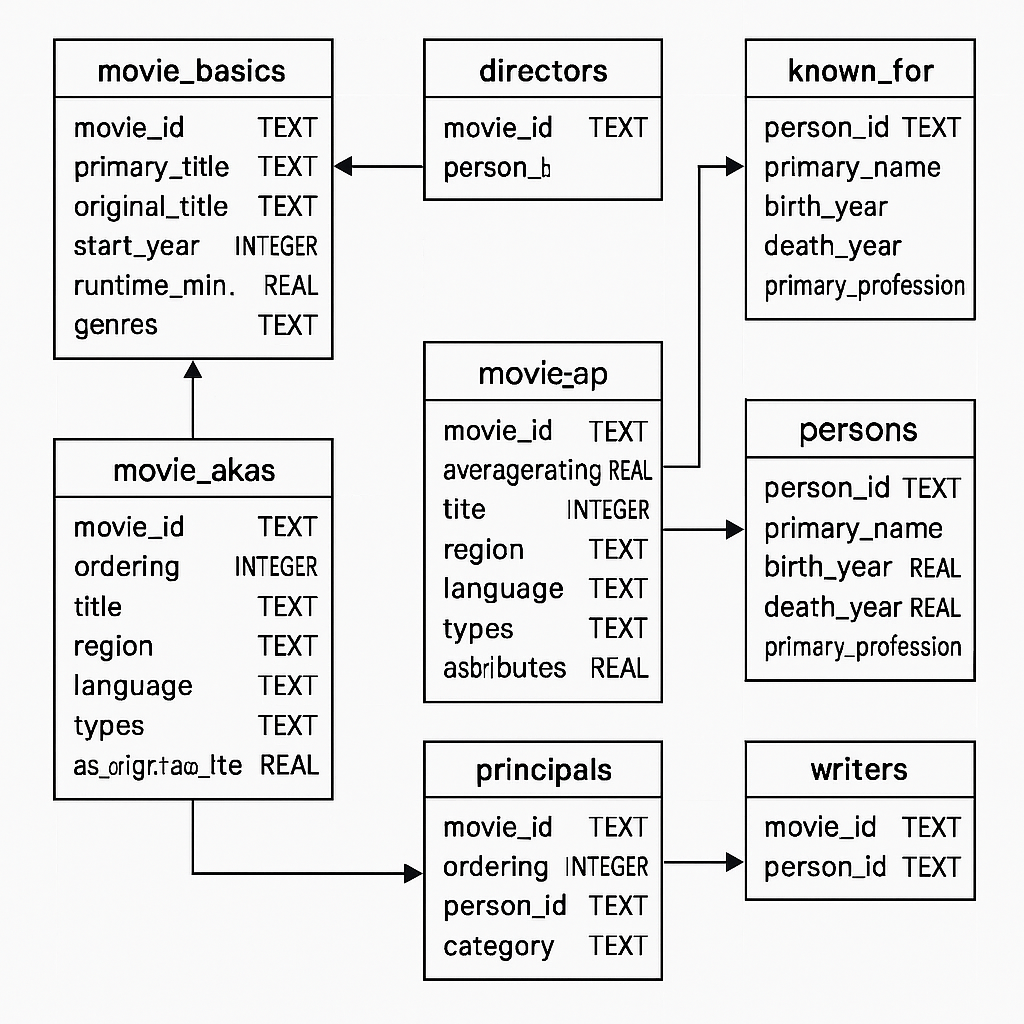

### Movie Basic

#### Genre Popularity

In [193]:
df = pd.read_sql("""
SELECT *
FROM movie_basics
""",con)
df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.00,None


In [194]:
pd.read_sql("""
SELECT genres, COUNT(*) AS count
FROM movie_basics
WHERE genres IS NOT NULL
GROUP BY genres
ORDER BY count DESC
""",con)

,genres,count
0,Documentary,32185
1,Drama,21486
2,Comedy,9177
3,Horror,4372
4,"Comedy,Drama",3519
...,...,...
1080,"Action,Animation,Music",1
1081,"Action,Animation,History",1
1082,"Action,Animation,Documentary",1
1083,"Action,Animation,Biography",1


Frequency of each individual genre. (Individual count, comedy alone or adventure alone)

In [195]:
# Assuming the DataFrame is named 'df'
# Step 1: Filter out invalid genre entries
valid_genres = df['genres'].dropna()  # Remove NaN
valid_genres = valid_genres[valid_genres != 'None']  # Remove string "None"
valid_genres = valid_genres[valid_genres != '']      # Remove empty strings

# Step 2: Split genres into lists and clean whitespace
split_genres = valid_genres.str.split(',').apply(lambda x: [g.strip() for g in x])

# Step 3: Explode the lists and count frequencies
exploded_genres = split_genres.explode()
genre_counts = exploded_genres.value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

genre_counts

,genre,count
0,Documentary,51640
1,Drama,49883
2,Comedy,25312
3,Thriller,11883
4,Horror,10805
5,Action,10335
6,Romance,9372
7,Biography,8722
8,Crime,6753
9,Adventure,6465


Frequency of genre combinations (e.g., Comedy, Drama) just to see if combinations do better than individual genre

In [196]:
# Step 1: Filter out both 'None' strings and actual null values
df_clean = df[(df['genres'].notna()) & (df['genres'] != 'None')].copy()

# Step 2: Process genres into sorted tuples
df_clean['genre_tuple'] = df_clean['genres'].apply(
    lambda x: tuple(sorted(g.strip() for g in x.split(',')))
)

# Step 3: Count genre combinations
genre_counts = df_clean['genre_tuple'].value_counts().reset_index()
genre_counts.columns = ['genre_combination', 'frequency']

# Convert tuple to readable string
genre_counts['combination_str'] = genre_counts['genre_combination'].apply(
    lambda x: ','.join(x)
)

# Step 4: Analyze single vs. multi-genre performance
genre_counts['genre_count'] = genre_counts['genre_combination'].apply(len)
single_genre_avg = genre_counts[genre_counts['genre_count'] == 1]['frequency'].mean()
multi_genre_avg = genre_counts[genre_counts['genre_count'] > 1]['frequency'].mean()

print(f"Average frequency of single genres: {single_genre_avg:.2f}")
print(f"Average frequency of multi-genre combinations: {multi_genre_avg:.2f}")
print(f"Do combinations perform better? {'Yes' if multi_genre_avg > single_genre_avg else 'No'}")

Average frequency of single genres: 3254.32
Average frequency of multi-genre combinations: 56.02
Do combinations perform better? No


Frequency Insight: The extreme disparity (3254 vs 56) suggests audience preference for clear genre positioning. Multi-genre movies face marketing challenges and niche audience targeting.


## Runtime

In [197]:
pd.read_sql("""
SELECT genres, ROUND(AVG(runtime_minutes), 2) AS 'Average runtime'
FROM movie_basics
WHERE genres IS NOT NULL
AND runtime_minutes IS NOT NULL
GROUP BY genres
ORDER BY ROUND(AVG(runtime_minutes), 2) DESC
""",con)

,genres,Average runtime
0,"Drama,Western",225.34
1,"Biography,Mystery,Sci-Fi",220.00
2,"History,Musical,Romance",174.00
3,"Action,Musical,Romance",170.00
4,"Musical,Romance,Thriller",165.00
...,...,...
1035,"Animation,Documentary,Sci-Fi",10.00
1036,"Drama,Horror,Short",7.00
1037,"Documentary,Mystery,Romance",7.00
1038,"Animation,Documentary,Horror",4.00


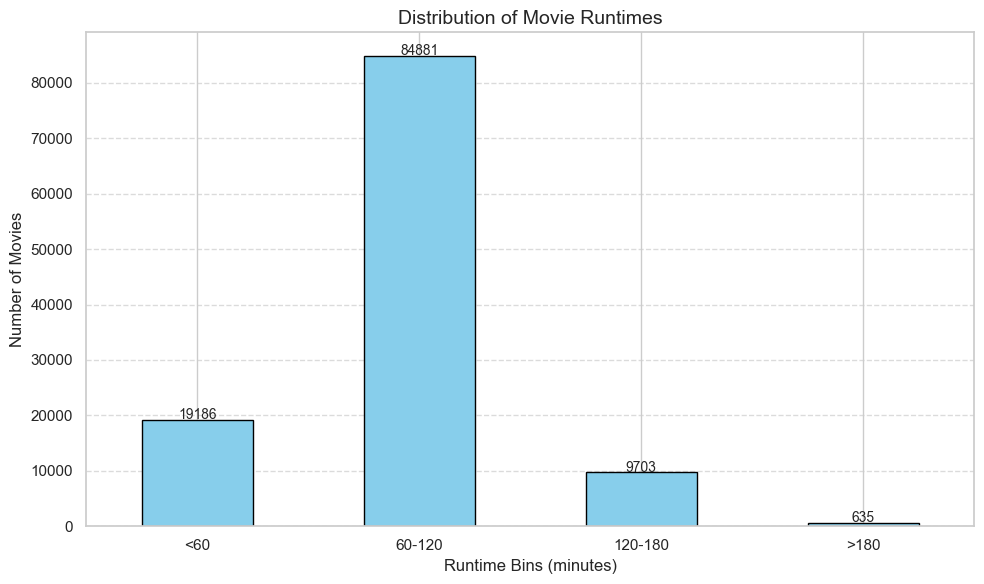

In [198]:

# Step 1: Filter out missing runtime values
df_clean = df[(df['runtime_minutes'].notna()) & (df['runtime_minutes'] != 'runtime_minutes')].copy()

# Step 2: Define bins and labels
bins = [0, 60, 120, 180, float('inf')]
labels = ['<60', '60-120', '120-180', '>180']

# Step 3: Categorize runtimes into bins
df_clean['runtime_bin'] = pd.cut(
    df_clean['runtime_minutes'],
    bins=bins,
    labels=labels,
    right=False  # Ensures [0,60), [60,120), etc.
)

# Step 4: Count movies per bin
bin_counts = df_clean['runtime_bin'].value_counts().reindex(labels, fill_value=0)

# Step 5: Plot histogram
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Runtimes', fontsize=14)
plt.xlabel('Runtime Bins (minutes)', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of bars
for i, count in enumerate(bin_counts):
    plt.text(i, count + 100, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Frequency Insight: The predominance of <60 min content suggests dataset includes non-theatrical works. Studio should focus analysis on 70+ min movies for relevant insights.

#### Movie Ratings

##### Rating Quality vs Popularity 
-  What movies are highly rated?
- we can filter out movies with low numvotes to focus on widely seen movies.

In [199]:
pd.read_sql("""
SELECT primary_title, averagerating, numvotes
FROM movie_basics AS mb
JOIN movie_ratings AS mr
ON mb.movie_id = mr.movie_id
WHERE numvotes > 100000
ORDER BY numvotes DESC
LIMIT 10
""",con)

,primary_title,averagerating,numvotes
0,Inception,8.80,1841066
1,The Dark Knight Rises,8.40,1387769
2,Interstellar,8.60,1299334
3,Django Unchained,8.40,1211405
4,The Avengers,8.10,1183655
5,The Wolf of Wall Street,8.20,1035358
6,Shutter Island,8.10,1005960
7,Guardians of the Galaxy,8.10,948394
8,Deadpool,8.00,820847
9,The Hunger Games,7.20,795227


#### Rank movies by average rating

In [200]:
pd.read_sql("""
SELECT primary_title, averagerating
FROM movie_basics AS mb
JOIN movie_ratings AS mr
ON mb.movie_id = mr.movie_id
ORDER BY averagerating DESC
LIMIT 10
""",con)

,primary_title,averagerating
0,Exteriores: Mulheres Brasileiras na Diplomacia,10.00
1,The Dark Knight: The Ballad of the N Word,10.00
2,Freeing Bernie Baran,10.00
3,Hercule contre Hermès,10.00
4,I Was Born Yesterday!,10.00
5,Dog Days in the Heartland,10.00
6,Revolution Food,10.00
7,Fly High: Story of the Disc Dog,10.00
8,All Around Us,10.00
9,The Paternal Bond: Barbary Macaques,10.00


#### Rank by both averagerating and numvotes

In [201]:
pd.read_sql("""
SELECT primary_title, averagerating, numvotes
FROM movie_basics AS mb
JOIN movie_ratings AS mr
ON mb.movie_id = mr.movie_id
WHERE numvotes > 100000
ORDER BY averagerating DESC, numvotes DESC
LIMIT 10
""",con)

,primary_title,averagerating,numvotes
0,The Mountain II,9.30,100568
1,Inception,8.80,1841066
2,Avengers: Endgame,8.80,441135
3,Interstellar,8.60,1299334
4,The Intouchables,8.50,677343
5,Avengers: Infinity War,8.50,670926
6,Whiplash,8.50,616916
7,Spider-Man: Into the Spider-Verse,8.50,210869
8,Dangal,8.50,123638
9,The Dark Knight Rises,8.40,1387769


In [202]:
pd.read_sql("""
SELECT ROUND(AVG(averagerating))
FROM movie_basics AS mb
JOIN movie_ratings AS mr
ON mb.movie_id = mr.movie_id
""",con)

,ROUND(AVG(averagerating))
0,6.00


#### Ratings 
- How are the ratings spread across all movies 

- A histogram of averagerating to identify what are the most common rating range (Is it 6-7 or 5-8)

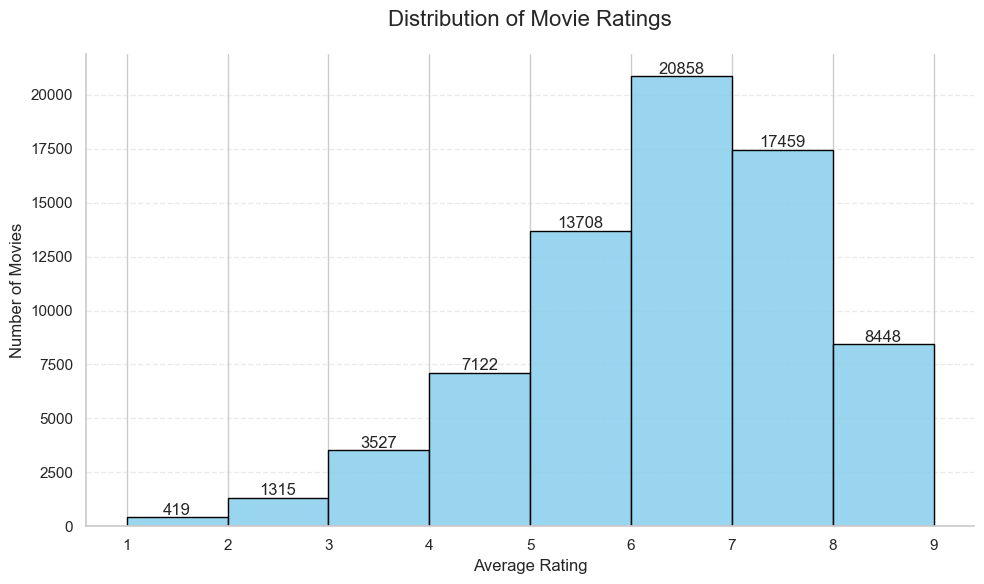

In [203]:
# Create DataFrame from the ratings table
ratings_df = pd.read_sql("""
SELECT *
FROM movie_basics AS mb
JOIN movie_ratings AS mr
ON mb.movie_id = mr.movie_id
""",con)

# Create styled histogram
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    data=ratings_df,
    x='averagerating',
    bins=[1, 2, 3, 4, 5, 6, 7, 8, 9],
    kde=False,
    color='skyblue',
    edgecolor='black',
    alpha=0.85,
    stat='count'
)

# Add count labels to bars
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', 
        xytext=(0, 5), 
        textcoords='offset points'
    )

# Customize plot
plt.title('Distribution of Movie Ratings', fontsize=16, pad=20)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()

plt.tight_layout()
plt.show()

- After identifying what the average rating is, we then can check per genre to tell us what is considered above average in this industry.

In [204]:


# Simulate merged data (since original tables don't share movie IDs)
np.random.seed(42)
movies = pd.read_sql("""
SELECT *
FROM movie_basics
""",con)

ratings = pd.read_sql("""
SELECT *
FROM movie_ratings
""",con)

merged = pd.merge(movies, ratings, on='movie_id')

# Split genres into separate rows
genre_ratings = merged.assign(genres=merged['genres'].str.split(',')).explode('genres')

In [205]:
overall_avg = merged['averagerating'].mean()
print(f"Overall Average Rating: {overall_avg:.2f}")

Overall Average Rating: 6.33


They should strive to have an average rating of 6.33 and above in order to do well in the market

In [206]:
genre_stats = (genre_ratings.groupby('genres', as_index=False)
                .agg(
                    avg_rating=('averagerating', 'mean'),
                    movie_count=('movie_id', 'nunique')
                )
                .sort_values('avg_rating', ascending=False))

# Calculate difference from overall average
genre_stats['vs_overall'] = genre_stats['avg_rating'] - overall_avg

genre_stats

,genres,avg_rating,movie_count,vs_overall
21,Short,8.80,1,2.47
7,Documentary,7.33,17753,1.00
11,Game-Show,7.30,2,0.97
17,News,7.27,579,0.94
4,Biography,7.16,3809,0.83
14,Music,7.09,1968,0.76
12,History,7.04,2825,0.71
22,Sport,6.96,1179,0.63
24,War,6.58,853,0.25
18,Reality-TV,6.50,17,0.17


C:\Users\user\AppData\Local\Temp\ipykernel_37268\3878841286.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


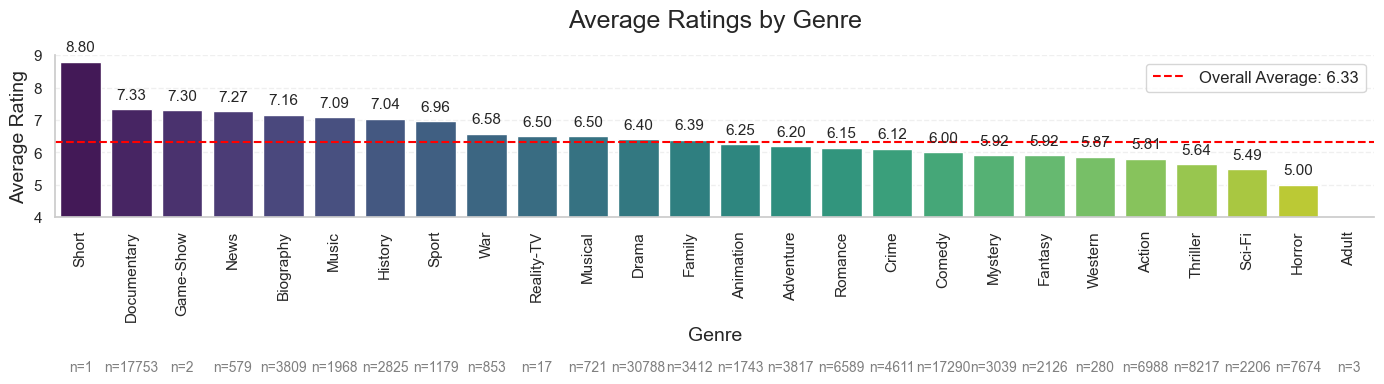

In [207]:
plt.figure(figsize=(14, 8))
bars = sns.barplot(
    data=genre_stats,
    x='genres',
    y='avg_rating',
    order=genre_stats.sort_values('avg_rating', ascending=False)['genres'],
    palette='viridis'
)

# Add reference line and annotations
plt.axhline(overall_avg, color='red', linestyle='--', 
            label=f'Overall Average: {overall_avg:.2f}')
plt.title('Average Ratings by Genre', fontsize=18, pad=20)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=90)  # Vertical x-axis labels
plt.legend(fontsize=12)

# Add value labels
for p in bars.patches:
    bars.annotate(
        f"{p.get_height():.2f}", 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        xytext=(0, 10), 
        textcoords='offset points',
        fontsize=11
    )

# Add count labels below x-axis
for i, genre in enumerate(genre_stats['genres']):
    count = genre_stats[genre_stats['genres'] == genre]['movie_count'].values[0]
    plt.text(i, -0.4, f'n={count}', 
             ha='center', va='top', fontsize=10, color='gray')

plt.ylim(4, 9)  # Adjust y-axis limits
plt.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

They should try and focus on the following genres that have an average rating above the mean average rating of 6.33

In [208]:
for genre in genre_stats['genres']:
    genre_vals = genre_ratings[genre_ratings['genres'] == genre]['averagerating']
    t_stat, p_val = stats.ttest_1samp(genre_vals, overall_avg)
    print(f"{genre}: p-value = {p_val:.4f} {'(significant)' if p_val < 0.05 else ''}")

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Short: p-value = nan 
Documentary: p-value = 0.0000 (significant)
Game-Show: p-value = 0.6707 
News: p-value = 0.0000 (significant)
Biography: p-value = 0.0000 (significant)
Music: p-value = 0.0000 (significant)
History: p-value = 0.0000 (significant)
Sport: p-value = 0.0000 (significant)
War: p-value = 0.0000 (significant)
Reality-TV: p-value = 0.7030 
Musical: p-value = 0.0031 (significant)
Drama: p-value = 0.0000 (significant)
Family: p-value = 0.0089 (significant)
Animation: p-value = 0.0093 (significant)
Adventure: p-value = 0.0000 (significant)
Romance: p-value = 0.0000 (significant)
Crime: p-value = 0.0000 (significant)
Comedy: p-value = 0.0000 (significant)
Mystery: p-value = 0.0000 (significant)
Fantasy: p-value = 0.0000 (significant)
Western: p-value = 0.0000 (significant)
Action: p-value = 0.0000 (significant)
Thriller: p-value = 0.0000 (significant)
Sci-Fi: p-value = 0.0000 (significant)
Horror: p-value = 0.0000 (significant)
Adult: p-value = 0.1534 


In [209]:
# Weight ratings by number of votes (if available)
genre_stats['weighted_avg'] = genre_ratings.groupby('genres').apply(
    lambda x: np.average(x['averagerating'], weights=x.get('numvotes', 1))
)
genre_stats

C:\Users\user\AppData\Local\Temp\ipykernel_37268\3117171657.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  genre_stats['weighted_avg'] = genre_ratings.groupby('genres').apply(


,genres,avg_rating,movie_count,vs_overall,weighted_avg
21,Short,8.80,1,2.47,NaN
7,Documentary,7.33,17753,1.00,NaN
11,Game-Show,7.30,2,0.97,NaN
17,News,7.27,579,0.94,NaN
4,Biography,7.16,3809,0.83,NaN
14,Music,7.09,1968,0.76,NaN
12,History,7.04,2825,0.71,NaN
22,Sport,6.96,1179,0.63,NaN
24,War,6.58,853,0.25,NaN
18,Reality-TV,6.50,17,0.17,NaN


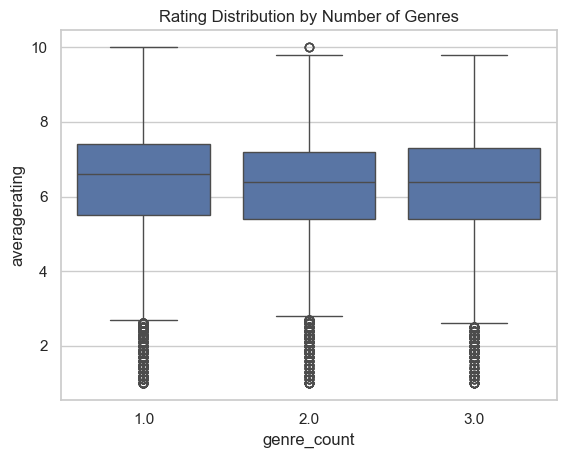

In [210]:
# Analyze multi-genre combinations
merged['genre_count'] = merged['genres'].str.count(',') + 1
sns.boxplot(data=merged, x='genre_count', y='averagerating')
plt.title('Rating Distribution by Number of Genres');

### Talent Influence (People Involved)   

- What effect does Director, Actor and Producer choice have on movie grossing?


- Are there directors or actors who are consistently associated with successful movies?

In [211]:
pd.read_sql("""
SELECT primary_name, COUNT(averagerating) as averagerating
FROM movie_basics AS mb
JOIN movie_ratings AS mr
ON mb.movie_id = mr.movie_id
JOIN directors as d
ON d.movie_id = mb.movie_id
JOIN persons as p
ON p.person_id = d.person_id
WHERE averagerating BETWEEN 5.0 AND 10
GROUP BY primary_name
ORDER BY averagerating DESC
            LIMIT 10
""",con)

,primary_name,averagerating
0,Tony Newton,153
1,Jason Impey,136
2,Shane Ryan,133
3,Ruben Rodriguez,128
4,Martin Sonntag,121
5,Gav Chuckie Steel,116
6,R.J. Wilson,100
7,Sam Mason-Bell,98
8,Evan Marlowe,98
9,Corey Norman,93


- Does having a well-known director or cast significantly influence box office success?

In [212]:
pd.read_sql("""
SELECT primary_name, Round(Avg(averagerating), 1) AS ratings, COUNT(mb.movie_id) AS 'Number of movies'
FROM movie_basics AS mb
JOIN movie_ratings AS mr
ON mb.movie_id = mr.movie_id
JOIN directors as d
ON d.movie_id = mb.movie_id
JOIN persons as p
ON p.person_id = d.person_id
JOIN known_for AS kf
ON kf.movie_id = mb.movie_id
JOIN principals AS pr
ON pr.movie_id = mb.movie_id
WHERE category = 'director'
GROUP BY primary_name
ORDER BY ratings DESC, COUNT(mb.movie_id) DESC 
LIMIT 10
""",con)

,primary_name,ratings,Number of movies
0,Loreto Di Cesare,10.00,14
1,Chad Carpenter,10.00,13
2,Emre Oran,10.00,11
3,Tristan David Luciotti,10.00,8
4,Masahiro Hayakawa,10.00,6
5,Michael J. Sanderson,10.00,6
6,Lindsay Thompson,10.00,1
7,Michiel Brongers,10.00,1
8,Stephen Peek,10.00,1
9,Raphael Sbarge,9.90,7


In [213]:
# we have a SQLite connection open in Python:
# Close any active connections
con = sqlite3.connect('im.db')
con.close()  # Important! This releases the file lock

### Recomendation

- Production budget alone does not reliably predict financial success. The studio should diversify investment and allocate resources strategically, factoring in marketing, distribution, and talent costs to maximize ROI.

- Prioritize collaboration with directors, producers, and lead actors who have consistently demonstrated positive impact on movie performance to improve profitability and audience engagement.
 
- Tailoring movie content to align with our audience preferences, while balancing creativity, will enhance market reception and box office returns.

- Understanding seasonal trends and optimal runtimes can improve audience turnout and overall performance.  Strategic scheduling of releases is recommended.
 
- Continuous market research is essential to stay ahead in a rapidly evolving industry by actively tracking top studios’ revenue patterns helps identify emerging trends and potential market gaps.


## Conclusion

Our analysis provides a foundational understanding to guide the launch of a new movie studio. However, there are some limitations and challenges to consider:
- The dataset does not capture the full financial cycle such as marketing budgets and revenue splits with theatres. These missing variables are critical for developing a comprehensive financial picture.
- The rise of streaming platforms like Netflix, Amazon Prime, and Disney presents both challenges and opportunities, which are not fully reflected in the data. The new studio should explore hybrid release strategies to adapt to this evolving landscape.

We encourage the stakeholders to expand their definition of success beyond traditional financial metrics like ROI and to include:
- Audience ratings and critical reception
- Streaming platform viewership,
- Award nominations and wins, which contribute to prestige and long term brand value.

While this analysis provides actionable insights into financial performance, talent influence, movie characteristics and strategic release planning of a movie, the studio’s ultimate success will rely on its ability to continuously adapt to industry shifts.